In [82]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

# Loading Data

In [94]:

data=pd.read_csv('data.csv', sep=",")
data.head(5)

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1


# Split Data into Training and Test Sets, tune parameters on training set using cross validation and Grid search then applying the optimal values to test set.


In [105]:
X = data.iloc[: , 1:23]
y = data.iloc[: , 23]
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.25, random_state=0)
print('Train set size %s' % (X_train.shape,))
print('Test set size %s' % (X_test.shape,))

Train set size (146, 22)
Test set size (49, 22)


## Combining transformers and estimators in a pipeline

In [106]:
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', KNeighborsClassifier())])

pipe_knn.fit(X_train, y_train)


Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

# Get Accuracy Score on test set 


In [107]:
print('Test Accuracy: %.3f' % pipe_knn.score(X_test, y_test))
y_pred = pipe_knn.predict(X_test)

Test Accuracy: 0.980


# Optimal K using cross_validation


In [98]:
k_range = range(1, 11)
# empty list to store scores
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X=X_train, y=y_train, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)

print('Length of list', len(k_scores))
print('Max of list', max(k_scores))



[0.82223443223443216, 0.76128205128205129, 0.80787545787545789, 0.80739926739926737, 0.82835164835164821, 0.84168498168498174, 0.82168498168498161, 0.82835164835164821, 0.80787545787545789, 0.81501831501831501]
('Length of list', 10)
('Max of list', 0.84168498168498174)


# Plotting Accuracy as a function of K 

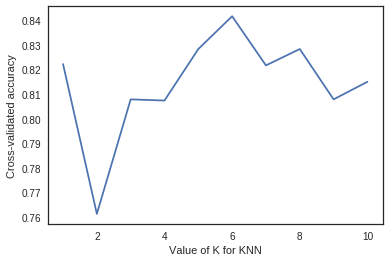

In [99]:
# plot how accuracy changes as we vary k
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

# Using the best K value according to cross validation

In [100]:
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=6)),
                    ('clf', KNeighborsClassifier())])

pipe_knn.fit(X_train, y_train)


# Instead of saving 10 scores in object named score and calculating mean
# We're just calculating the mean directly on the results

y_pred = pipe_knn.predict(X_test)
print('Test Accuracy: %.3f' % pipe_knn.score(X_test, y_test))
y_pred = pipe_knn.predict(X_test)

Test Accuracy: 0.918


# Optimal k using Grid search

In [101]:
from sklearn.grid_search import GridSearchCV

tuned_params = [{'clf__n_neighbors':[4,5,6,7,8,9,10]}]
gs = GridSearchCV(estimator=pipe_knn, 
                  param_grid=tuned_params, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.883561643836
{'clf__n_neighbors': 4}


# Using the Optimal k Value

In [102]:
# evaluate the model (using the value K=5)
# The accuracy is the same as previous.
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', KNeighborsClassifier(n_neighbors=4))])
pipe_knn.fit(X_train, y_train)


print('Test Accuracy: %.3f' % pipe_knn.score(X_test, y_test))
y_pred = pipe_knn.predict(X_test)

Test Accuracy: 0.939


# Plot Learning and Validation Curves

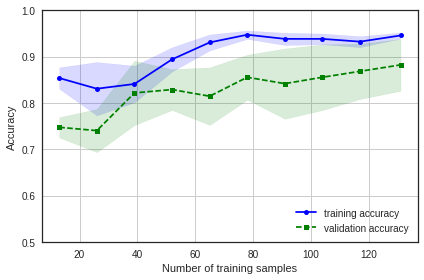

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier(n_neighbors=5))])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_knn, 
                                                        X=X_train, 
                                                        y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

# the plot shows a good bias-variance trade-off